In [35]:
import pandas as pd

df_train = pd.read_csv('data challange/train_preprocess.tsv.txt',sep='\t',names=["Teks", "Target"])
df_valid = pd.read_csv('data challange/valid.csv',sep='\t',names=["Teks", "Target"])

df = df_train.append(df_valid, ignore_index=True)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12668\4237232154.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_train.append(df_valid, ignore_index=True)


In [36]:
df_test = pd.read_csv('data challange/test.csv',sep='\t',names=["Teks", "Target"])

df = df.append(df_test, ignore_index=True)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12668\599489437.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_test, ignore_index=True)


In [37]:
df.head()

,Teks,Target
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [38]:
df['Target'].value_counts()

positive    6416
negative    3436
neutral     1148
Name: Target, dtype: int64

In [39]:
df.isnull().sum()

Teks        0
Target    502
dtype: int64

In [40]:
df=df.dropna()

In [41]:
df.isnull().sum()

Teks      0
Target    0
dtype: int64

<AxesSubplot:xlabel='Target'>

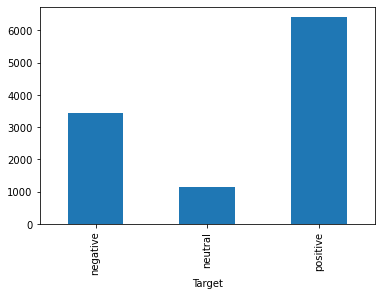

In [42]:
import matplotlib.pyplot as plt
df.groupby('Target').size().plot(kind='bar')

# **Text Normalization/Cleansing**

In [43]:
import re 

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

def lowercase(string):
    return string.lower() 

def remove_unnecessary_char(string):
    string = re.sub('\n',' ',string) # Remove every '\n'
    string = re.sub('rt',' ',string) # Remove every retweet symbol
    string = re.sub('user',' ',string) # Remove every username
    string = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',string) # Remove every URL
    string = re.sub('  +', ' ', string) # Remove extra spaces
    string = re.sub(r'pic.twitter.com.[\w]+', '', string) # Remove every pic 
    string = re.sub('gue','saya',string) # replace gue - saya
    string = re.sub(r':', '', string) #Remove symbol 
    string = re.sub(r'‚Ä¶', '', string) #Remove symbol Ä¶
    return string   

In [44]:
df['Teks_clean'] = df.Teks.apply(cleansing)

In [45]:
df.head()

,Teks,Target,Teks_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung t...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kas...


In [46]:
neg = df.loc[df['Target'] == 'negative'].Teks_clean.tolist()
neu = df.loc[df['Target'] == 'neutral'].Teks_clean.tolist()
pos = df.loc[df['Target'] == 'positive'].Teks_clean.tolist()

neg_label = df.loc[df['Target'] == 'negative'].Target.tolist()
neu_label = df.loc[df['Target'] == 'neutral'].Target.tolist()
pos_label = df.loc[df['Target'] == 'positive'].Target.tolist()

In [47]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


# **Feature Extraction** 

In [48]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


# **Prepare train & test datasets/Splitting Dataset**

Split dataset menjadi 80% untuk train dan 20% untuk test.

In [49]:
from sklearn.model_selection import train_test_split

file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

FileNotFoundError: [Errno 2] No such file or directory: 'x_pad_sequences.pickle'

# **Training**

In [ ]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

In [ ]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs=7, batch_size=10, validation_data=(X_test, y_test), verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 96, 100)           10000000  
                                                                 
 lstm_3 (LSTM)               (None, 64)                42240     
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/7
880/880 [==============================] - 126s 142ms/step - loss: 0.4558 - accuracy: 0.8155 - val_loss: 0.3261 - val_accuracy: 0.8795
Epoch 2/7
880/880 [==============================] - 114s 129ms/step - loss: 0.1960 - accuracy: 0.9287 - val_loss: 0.3447 - val_accuracy: 0.8755
Epoch 3/7
8

# **evaluasi**

In [ ]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 3s 35ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       685
           1       0.74      0.76      0.75       233
           2       0.91      0.90      0.91      1282

    accuracy                           0.86      2200
   macro avg       0.82      0.83      0.83      2200
weighted avg       0.86      0.86      0.86      2200



## **cross validation**

In [ ]:
# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

69/69 [==============================] - 2s 18ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       685
           1       0.79      0.82      0.81       233
           2       0.92      0.91      0.92      1282

    accuracy                           0.88      2200
   macro avg       0.85      0.86      0.85      2200
weighted avg       0.88      0.88      0.88      2200



/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


69/69 [==============================] - 3s 27ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.87      0.76      0.81       685
           1       0.75      0.84      0.79       233
           2       0.89      0.93      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.84      0.84      0.84      2200
weighted avg       0.87      0.87      0.87      2200



/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


69/69 [==============================] - 2s 16ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       685
           1       0.80      0.82      0.81       233
           2       0.91      0.90      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.85      0.85      0.85      2200
weighted avg       0.87      0.87      0.87      2200



/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


69/69 [==============================] - 2s 17ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       685
           1       0.80      0.80      0.80       233
           2       0.93      0.88      0.90      1282

    accuracy                           0.87      2200
   macro avg       0.84      0.85      0.84      2200
weighted avg       0.87      0.87      0.87      2200



/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


69/69 [==============================] - 2s 16ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       685
           1       0.81      0.80      0.81       233
           2       0.90      0.93      0.91      1282

    accuracy                           0.88      2200
   macro avg       0.86      0.85      0.85      2200
weighted avg       0.88      0.88      0.88      2200




Rata-rata Accuracy:  0.8731818181818183


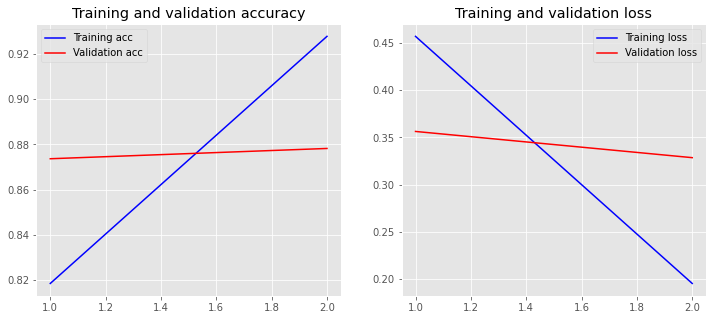

In [ ]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [ ]:
model.save('model.h5')
print("Model has created!")

Model has created!


## **Predict**

In [ ]:
import re 
from keras.models import load_model

input_text = """
Rasa syukur, cukup.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

def lowercase(string):
    return string.lower() 

def remove_unnecessary_char(string):
    string = re.sub('\n',' ',string) # Remove every '\n'
    string = re.sub('rt',' ',string) # Remove every retweet symbol
    string = re.sub('user',' ',string) # Remove every username
    string = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',string) # Remove every URL
    string = re.sub('  +', ' ', string) # Remove extra spaces
    string = re.sub(r'pic.twitter.com.[\w]+', '', string) # Remove every pic 
    string = re.sub('gue','saya',string) # replace gue - saya
    string = re.sub(r':', '', string) #Remove symbol 
    string = re.sub(r'‚Ä¶', '', string) #Remove symbol Ä¶
    return string   

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 0s 461ms/step
Text:   rasa syukur  cukup  
Sentiment:  positive


In [ ]:
input_text = """
dasar anak anjing gatau diri.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

def lowercase(string):
    return string.lower() 

def remove_unnecessary_char(string):
    string = re.sub('\n',' ',string) # Remove every '\n'
    string = re.sub('rt',' ',string) # Remove every retweet symbol
    string = re.sub('user',' ',string) # Remove every username
    string = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',string) # Remove every URL
    string = re.sub('  +', ' ', string) # Remove extra spaces
    string = re.sub(r'pic.twitter.com.[\w]+', '', string) # Remove every pic 
    string = re.sub('gue','saya',string) # replace gue - saya
    string = re.sub(r':', '', string) #Remove symbol 
    string = re.sub(r'‚Ä¶', '', string) #Remove symbol Ä¶
    return string   

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 0s 427ms/step
Text:   dasar anak anjing gatau diri  
Sentiment:  negative


In [ ]:
input_text = """
suatu hari saya ingin bermain bola.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

def lowercase(string):
    return string.lower() 

def remove_unnecessary_char(string):
    string = re.sub('\n',' ',string) # Remove every '\n'
    string = re.sub('rt',' ',string) # Remove every retweet symbol
    string = re.sub('user',' ',string) # Remove every username
    string = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',string) # Remove every URL
    string = re.sub('  +', ' ', string) # Remove extra spaces
    string = re.sub(r'pic.twitter.com.[\w]+', '', string) # Remove every pic 
    string = re.sub('gue','saya',string) # replace gue - saya
    string = re.sub(r':', '', string) #Remove symbol 
    string = re.sub(r'‚Ä¶', '', string) #Remove symbol Ä¶
    return string   

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 2s 2s/step
Text:   suatu hari saya ingin bermain bola  
Sentiment:  neutral
